In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, auc, roc_curve
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/Users/natalie/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def find_best_threshold_f1_score(train_labels, oofs, average='macro'):
    scores = []
    thresholds = []
    best_score = 0
    best_threshold = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (oofs > threshold).astype('int')
        m = f1_score(train_labels, preds, average=average)
        scores.append(m)
        thresholds.append(threshold)
        if m > best_score:
            best_score = m
            best_threshold = threshold
    return best_threshold, best_score

In [3]:
with open(f"/Users/natalie/Desktop/DS Thesis/user-churn-prediction/checkpoints/nothing_model_after_tune.pkl", "rb") as f:
    nothing_loadded = pickle.load(f)
with open(f"/Users/natalie/Desktop/DS Thesis/user-churn-prediction/checkpoints/smote_model_after_tune.pkl", "rb") as f:
    smote_loadded = pickle.load(f)
with open(f"/Users/natalie/Desktop/DS Thesis/user-churn-prediction/checkpoints/class_weight_model_after_tune.pkl", "rb") as f:
    class_weight_loadded = pickle.load(f)
with open(f"/Users/natalie/Desktop/DS Thesis/user-churn-prediction/checkpoints/under_sampling_model_after_tune.pkl", "rb") as f:
    under_sampling_loadded = pickle.load(f)
with open("/Users/natalie/Desktop/DS Thesis/user-churn-prediction/checkpoints/nothing_ensemble_after_tune.pkl", "rb") as f:
    nothing_ensemble_loadded = pickle.load(f)
with open("/Users/natalie/Desktop/DS Thesis/user-churn-prediction/checkpoints/smote_ensemble_after_tune.pkl", "rb") as f:
    smote_ensemble_loadded = pickle.load(f)
with open("/Users/natalie/Desktop/DS Thesis/user-churn-prediction/checkpoints/under_sampling_ensemble_after_tune.pkl", "rb") as f:
    under_sampling_ensemble_loadded = pickle.load(f)
test = pd.read_parquet("/Users/natalie/Desktop/DS Thesis/Code/data/test.parquet")
train = pd.read_parquet("/Users/natalie/Desktop/DS Thesis/Code/data/train.parquet")

In [4]:
# drop column province
test = test.drop(columns=['province'])
train = train.drop(columns=['province'])

In [5]:
MODEL_NAMES = ['lr', 'rf', 'lgb', 'xgb', 'mlp', 'blend', 'stack']
nothing_score_df = nothing_loadded['score_df']
nothing_oofs = nothing_loadded['oofs']
nothing_models = nothing_loadded['models']
nothing_predictions = nothing_loadded['predictions']

smote_score_df = smote_loadded['score_df']
smote_oofs = smote_loadded['oofs']
smote_models = smote_loadded['models']
smote_predictions = smote_loadded['predictions']

class_weight_score_df = class_weight_loadded['score_df']
class_weight_oofs = class_weight_loadded['oofs']
class_weight_df_models = class_weight_loadded['models']
class_weight_predictions = class_weight_loadded['predictions']

under_sampling_score_df = under_sampling_loadded['score_df']
under_sampling_oofs = under_sampling_loadded['oofs']
under_sampling_models = under_sampling_loadded['models']
under_sampling_predictions = under_sampling_loadded['predictions']


nothing_ensemble_score_df = nothing_ensemble_loadded['score_df']
nothing_ensemble_predictions = nothing_ensemble_loadded['predictions']

smote_ensemble_score_df = smote_ensemble_loadded['score_df']
smote_ensemble_predictions = smote_ensemble_loadded['predictions']

under_sampling_ensemble_score_df = under_sampling_ensemble_loadded['score_df']
under_sampling_ensemble_predictions = under_sampling_ensemble_loadded['predictions']

In [6]:
nothing_score_df = pd.concat([nothing_score_df,nothing_ensemble_score_df], axis=0).reset_index(drop=True)
smote_score_df = pd.concat([smote_score_df,smote_ensemble_score_df],axis=0).reset_index(drop=True)
under_sampling_score_df = pd.concat([under_sampling_score_df, under_sampling_ensemble_score_df], axis=0).reset_index(drop=True)

In [7]:
smote_ensemble_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,blend,0.830165,0.780505,0.898723,0.864358,0.724584
1,stack,0.827860,0.781572,0.900634,0.852695,0.751175


In [8]:
nothing_ensemble_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,blend,0.832705,0.782260,0.900169,0.869792,0.718187
1,stack,0.830260,0.783443,0.901558,0.857341,0.746638


In [9]:
y_test = test['churn_user']

In [10]:
import matplotlib
font = {'size'   : 25}
matplotlib.rc('font', **font)

def gen_data(model_name='xgb'):
    x0 = nothing_score_df[nothing_score_df.model_name==model_name]
    x0['method'] = 'not_handle'
    x1 = smote_score_df[smote_score_df.model_name==model_name]
    x1['method'] = 'smote'
    x2 = class_weight_score_df[class_weight_score_df.model_name==model_name]
    x2['method'] = 'class_weight'
    x3 = under_sampling_score_df[under_sampling_score_df.model_name==model_name]
    x3['method'] = 'under_sampling' 
    scores = pd.concat([x0, x1, x2, x3])
    return scores 
def plot_handle_imbalanced(model_name, title):
    scores = gen_data(model_name)
    fig, axes = plt.subplots(3, 2, figsize=(30,30))
    sns.barplot(x='method', y='accuracy_score', data=scores, ax=axes[0,0])
    for i, val in enumerate(scores['accuracy_score'].values):
        axes[0,0].text(i-0.2, val+0.01, round(val, 4))
    axes[0,0].set_ylim(0,1)
    axes[0,0].set_title("accuracy score")

    sns.barplot(x='method', y='f1_score', data=scores, ax=axes[0,1])
    for i, val in enumerate(scores['f1_score'].values):
        axes[0,1].text(i-0.2, val+0.01, round(val, 4))
    axes[0,1].set_ylim(0,1)
    axes[0,1].set_title("f1-score")

    sns.barplot(x='method', y='auc_score', data=scores, ax=axes[1,0])
    for i, val in enumerate(scores['auc_score'].values):
        axes[1,0].text(i-0.2, val+0.01, round(val, 4))
    axes[1,0].set_ylim(0,1)
    axes[1,0].set_title("auc score")

    sns.barplot(x='method', y='specificity_score', data=scores, ax=axes[1,1])
    for i, val in enumerate(scores['specificity_score'].values):
        axes[1,1].text(i-0.2, val+0.01, round(val, 4))
    axes[1,1].set_ylim(0,1)
    axes[1,1].set_title("specificity score")

    sns.barplot(x='method', y='sensitivity_score', data=scores, ax=axes[2,0])
    for i, val in enumerate(scores['sensitivity_score'].values):
        axes[2, 0].text(i-0.2, val+0.01, round(val, 4))
    axes[2, 0].set_ylim(0,1)
    axes[2, 0].set_title("sensitivity score")
    plt.suptitle(title)
    plt.tight_layout()
    return fig

In [160]:
# log_reg_fig = plot_handle_imbalanced(MODEL_NAMES[0], "Logistic Regression")
# rf_fig = plot_handle_imbalanced(MODEL_NAMES[1], "Random Forest")
# lightgbm_fig = plot_handle_imbalanced(MODEL_NAMES[2], "Lightgbm")
# xgboost_fig = plot_handle_imbalanced(MODEL_NAMES[3], "Xgboost")
# mlp_fig = plot_handle_imbalanced(MODEL_NAMES[4], "MLP")

In [11]:
under_sampling_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.824245,0.766589,0.878957,0.874571,0.668847
1,randomforest,0.832280,0.781785,0.899697,0.869322,0.717901
2,lightgbm,0.831805,0.782515,0.901113,0.865715,0.727098
3,xgboost,0.832850,0.783392,0.901276,0.867581,0.725606
4,mlp,0.832575,0.779531,0.898271,0.875783,0.699158
5,blend,0.832055,0.781559,0.899805,0.869011,0.717941
6,stack,0.830325,0.783198,0.901322,0.858228,0.744165


In [12]:
nothing_score_df['model_name'] = MODEL_NAMES
class_weight_score_df['model_name'] = MODEL_NAMES[:-2]
smote_score_df['model_name'] = MODEL_NAMES
under_sampling_score_df['model_name'] = MODEL_NAMES

In [13]:
nothing_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,lr,0.823535,0.764205,0.878730,0.877153,0.657973
1,rf,0.832955,0.782272,0.899681,0.870719,0.716347
2,lgb,0.833370,0.783380,0.901482,0.869614,0.721457
3,xgb,0.832400,0.783761,0.901587,0.864921,0.731983
4,mlp,0.833110,0.780509,0.898511,0.875498,0.702224
5,blend,0.832705,0.782260,0.900169,0.869792,0.718187
6,stack,0.830260,0.783443,0.901558,0.857341,0.746638


In [14]:
class_weight_score_df['method'] = 'class weight'
nothing_score_df['method'] = 'no handle'
smote_score_df['method'] = 'smote'
under_sampling_score_df['method'] = 'under sampling'

In [15]:
class_weight_score_df.iloc[4,1:-1] = 0

In [16]:
class_weight_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score,method
0,lr,0.828375,0.765944,0.878951,0.890186,0.637514,class weight
1,rf,0.830845,0.781587,0.899726,0.864305,0.727527,class weight
2,lgb,0.833755,0.782715,0.901285,0.872698,0.713506,class weight
3,xgb,0.833635,0.783574,0.901422,0.870156,0.720864,class weight
4,mlp,0.000000,0.000000,0.000000,0.000000,0.000000,class weight


In [17]:
x = pd.concat([nothing_score_df,class_weight_score_df,smote_score_df,under_sampling_score_df])
# x.set_index(['method','model_name']).transpose().to_csv('../outputs/data2.csv')

In [18]:
x[['model_name', 'method']+list(x.columns[1:-1])].to_csv('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/data4.csv')

lr


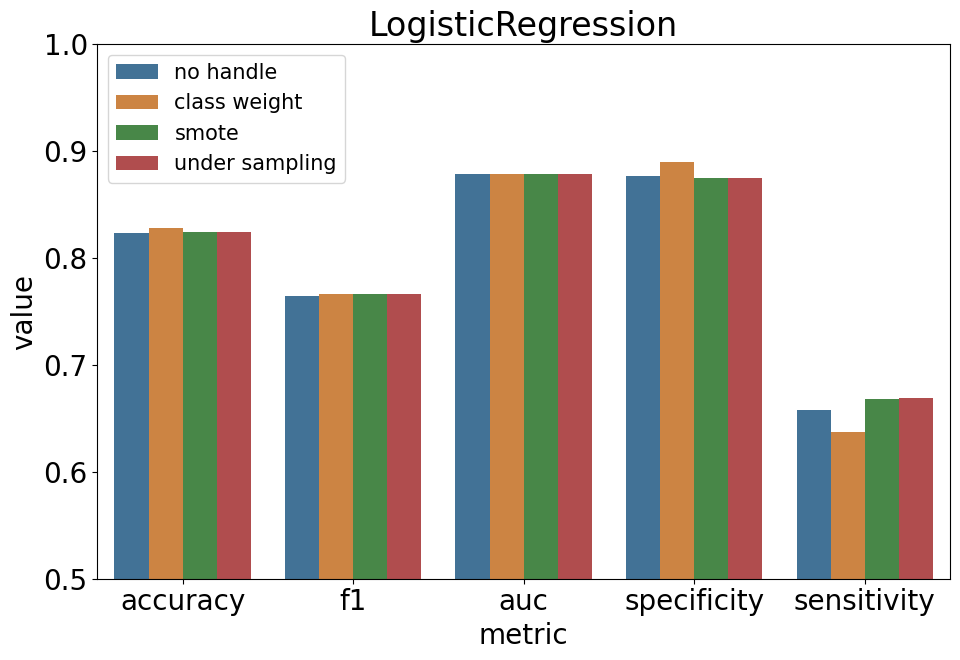

In [21]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
x_plot = x.melt(id_vars=['model_name', 'method'], value_vars=x.columns[1:-1])
x_plot['metric'] = x_plot['variable'].str.split('_').str.get(0)
x_plot = x_plot[x_plot.value>0]
def plot_handle_imbalanced(model_name='lr', title="", palette=None):
    print(model_name)
    fig = plt.figure(figsize=(10,7))
    sns.barplot(x='metric', y='value', hue='method',data=x_plot[x_plot.model_name==model_name], palette=palette)
    plt.ylim(0.5,1)
    # plt.legend(bbox_to_anchor=(0.63, -0.2))
    plt.legend(loc="upper left",prop={'size': 15})
    plt.title(title)
    plt.tight_layout()

    return fig
lr_fig = plot_handle_imbalanced(MODEL_NAMES[0], 'LogisticRegression',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
lr_fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/h_lr.png')

rf


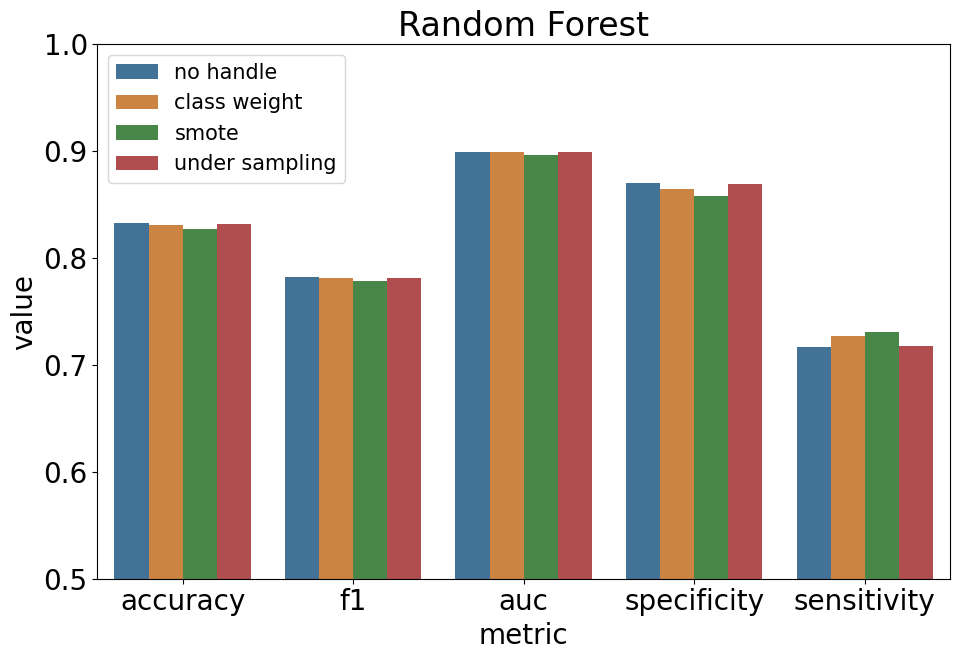

In [22]:
rf_fig = plot_handle_imbalanced(MODEL_NAMES[1], 'Random Forest',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
rf_fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/h_rf.png')

lgb


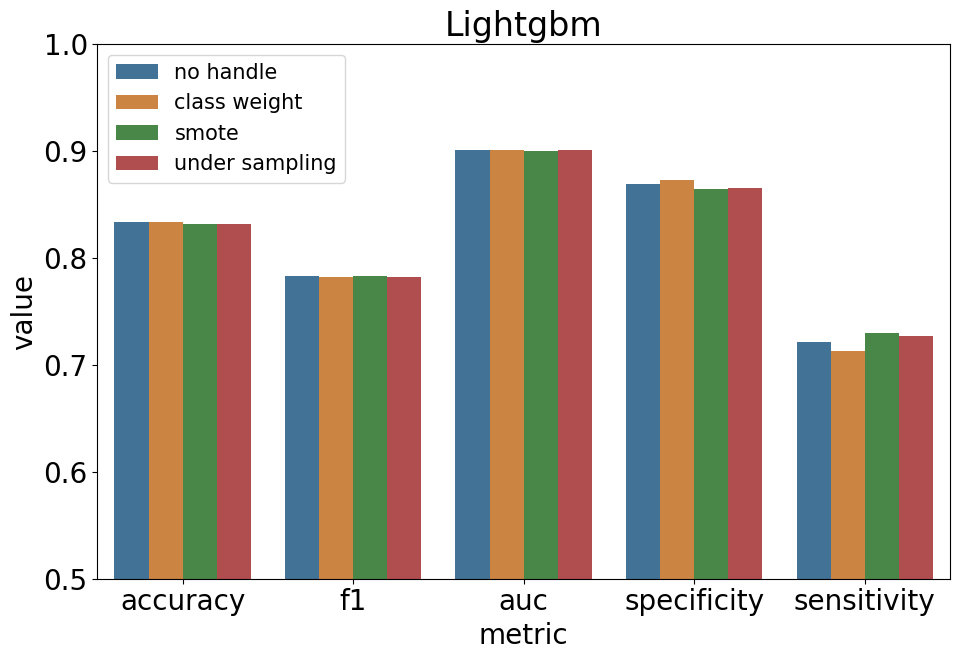

In [23]:
lgb_fig = plot_handle_imbalanced(MODEL_NAMES[2], 'Lightgbm',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
lgb_fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/h_lgb.png')

xgb


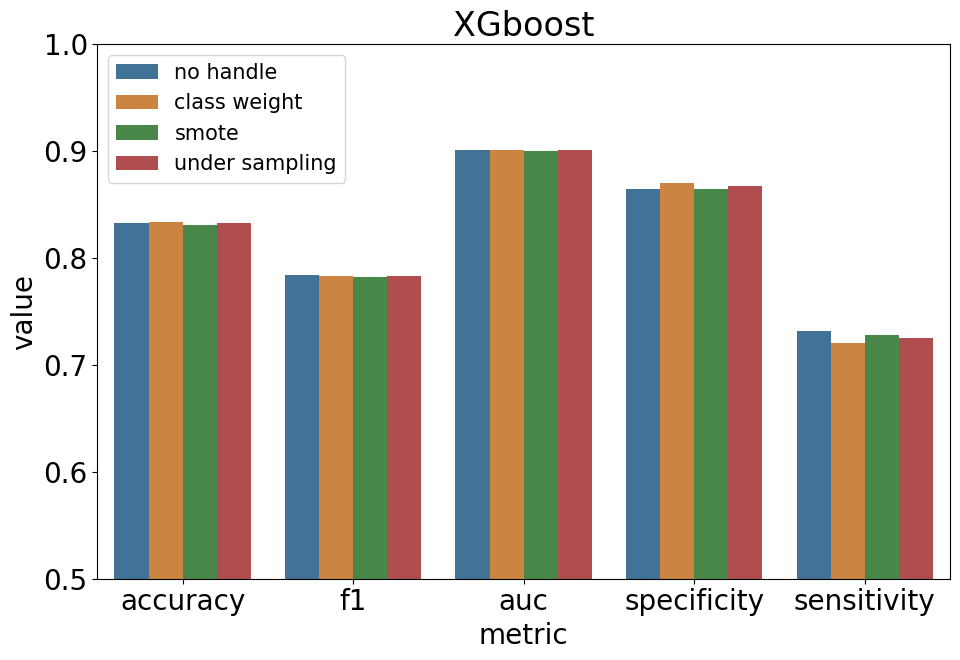

In [24]:
xgb_fig = plot_handle_imbalanced(MODEL_NAMES[3], 'XGboost',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
xgb_fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/h_xgb.png')

mlp


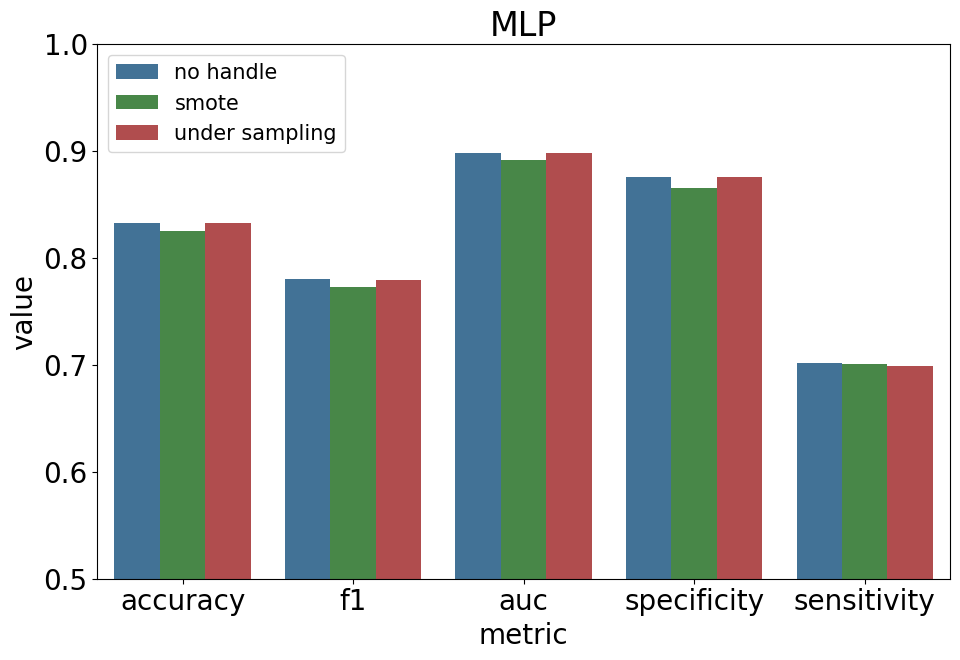

In [25]:
mlp_fig = plot_handle_imbalanced(MODEL_NAMES[4], 'MLP',palette=["#3474a4", "#3d923d","#c03d3e"])
mlp_fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/h_mlp.png')

blend


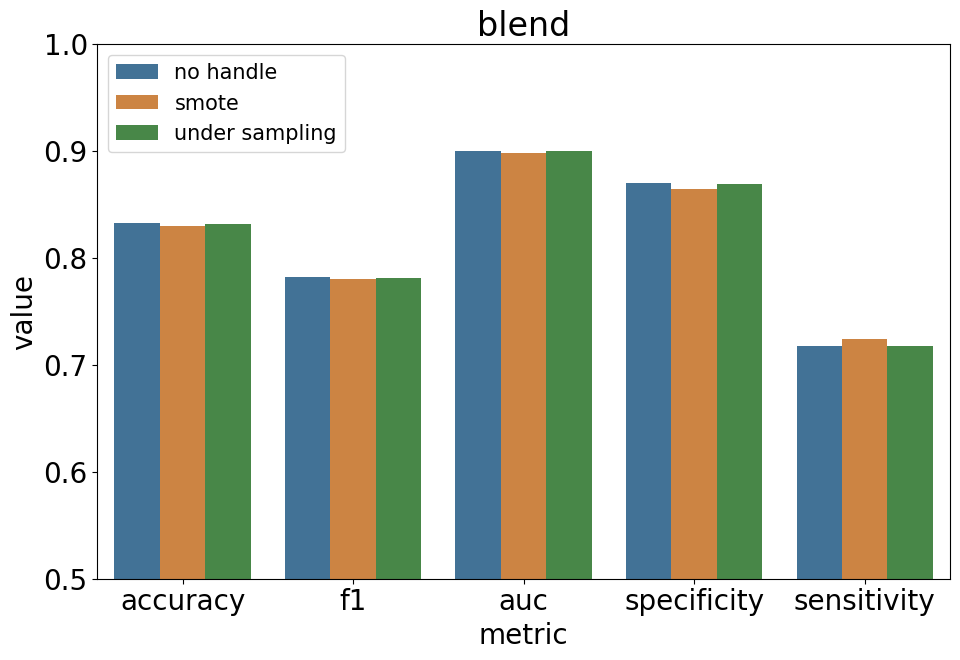

In [26]:
mlp_fig = plot_handle_imbalanced(MODEL_NAMES[5], 'blend', palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
mlp_fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/h_blend.png')

stack


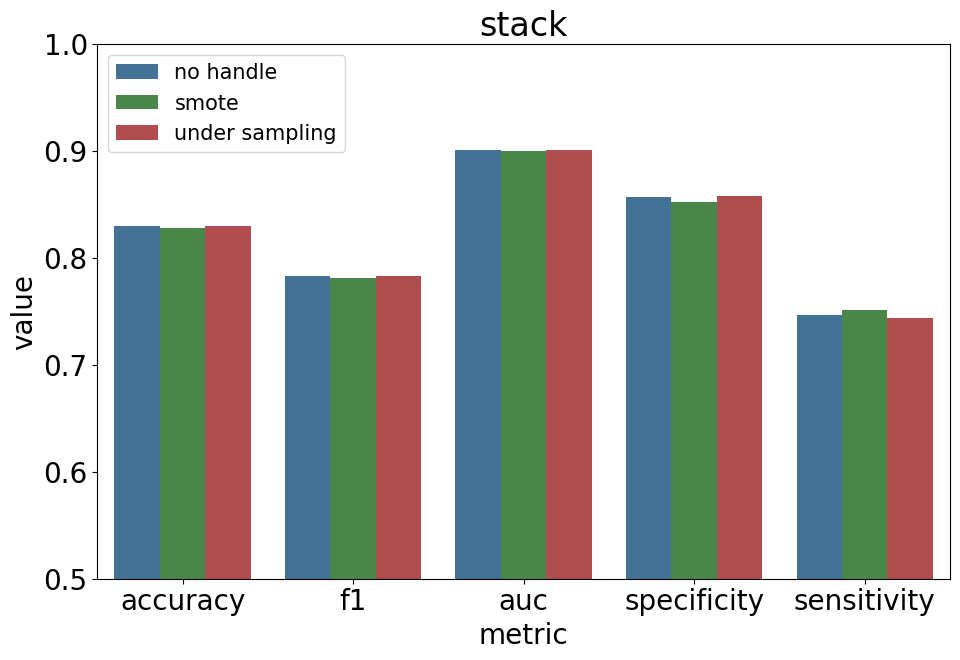

In [27]:
mlp_fig = plot_handle_imbalanced(MODEL_NAMES[6], 'stack', palette=["#3474a4", "#3d923d","#c03d3e"])
mlp_fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/h_stack.png')

In [28]:
def plot_roc_curve(y_true, y_pred_prob, show_threshold=False, **params):
    """
        A function plot Roc AUC.
                Parameters:
                            y_true: Array
                                True label
                            y_pred_prob: Array
                                Probability predicted label
                            show_threshold: Bool
                                Show threshold
                Returns:
                            figure: Figure
                            roc_auc: AUC value
    """

    figure = plt.figure(figsize=params.get('figsize', (17, 10)))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    if show_threshold:
        ax2 = plt.gca().twinx()
        ax2.plot(fpr, thresholds, markeredgecolor='r',
                 linestyle='dashed', color='r')
        ax2.set_ylabel('Threshold', color='r')
        ax2.set_ylim([0.0, 1.0])
        ax2.set_xlim([0.0, 1.0])

    plt.show()

    return figure, roc_auc


def plot_multi_roc_curve(y_trues, y_pred_probs, labels, title="",**params):
    """
        A function plot Roc AUC.
                Parameters:
                            y_trues: Array of Array
                                True label
                            y_pred_probs: Array of Array
                                Probability predicted label
                            labels: List
                                List of label
                Returns:
                            figure: Figure
                            roc_aucs: List AUC value
    """

    figure = plt.figure(figsize=params.get('figsize', (12, 10)))
    roc_aucs = []
    for y_true, y_pred_prob, label in zip(y_trues, y_pred_probs, labels):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f'{label} ROC curve (area = %0.5f)' % roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve {title}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return figure, roc_aucs

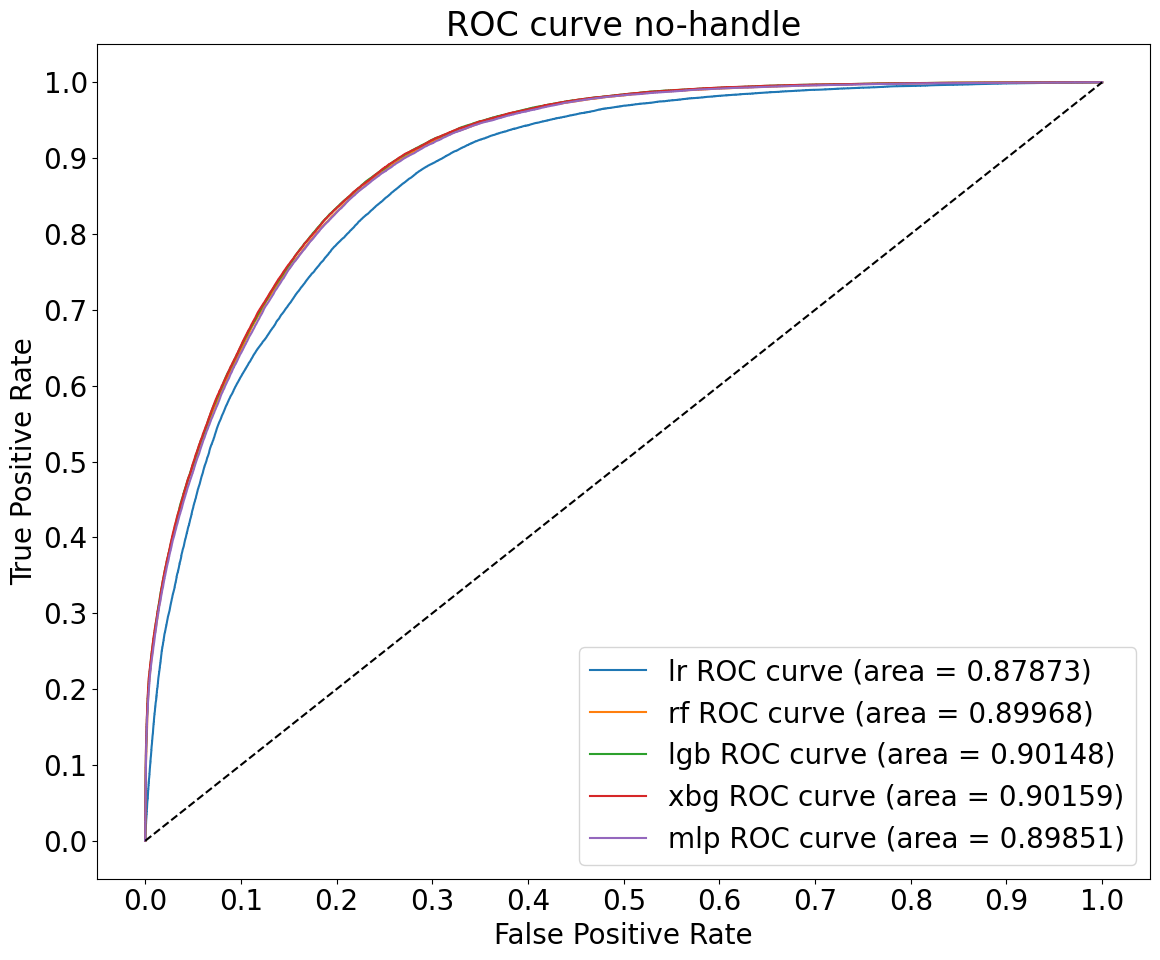

In [29]:
fig,_ = plot_multi_roc_curve([y_test,y_test,y_test,y_test,y_test], nothing_predictions, title='no-handle',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/roc_no_handle.png')

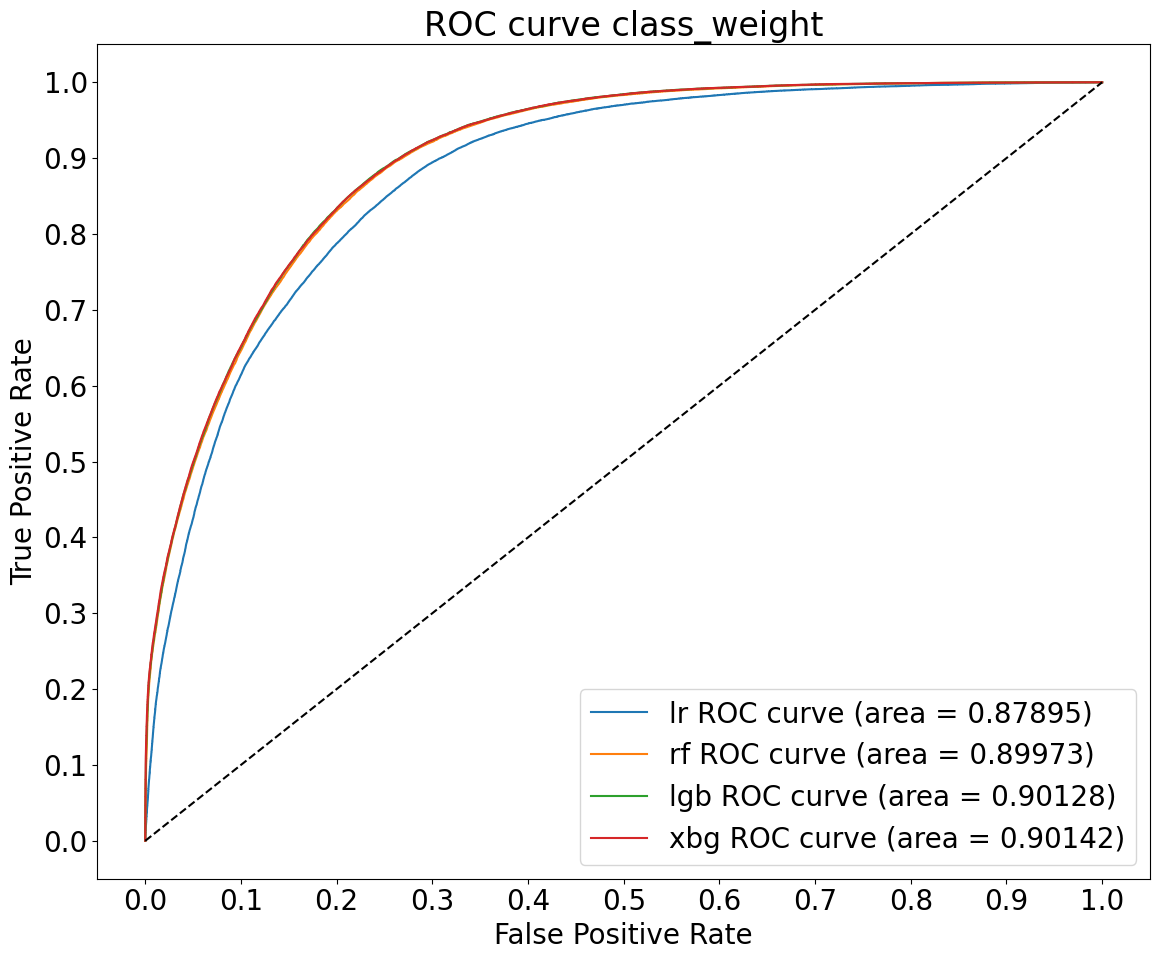

In [30]:
fig, _ = plot_multi_roc_curve([y_test,y_test,y_test,y_test], class_weight_predictions, title='class_weight',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/roc_class_weight.png')

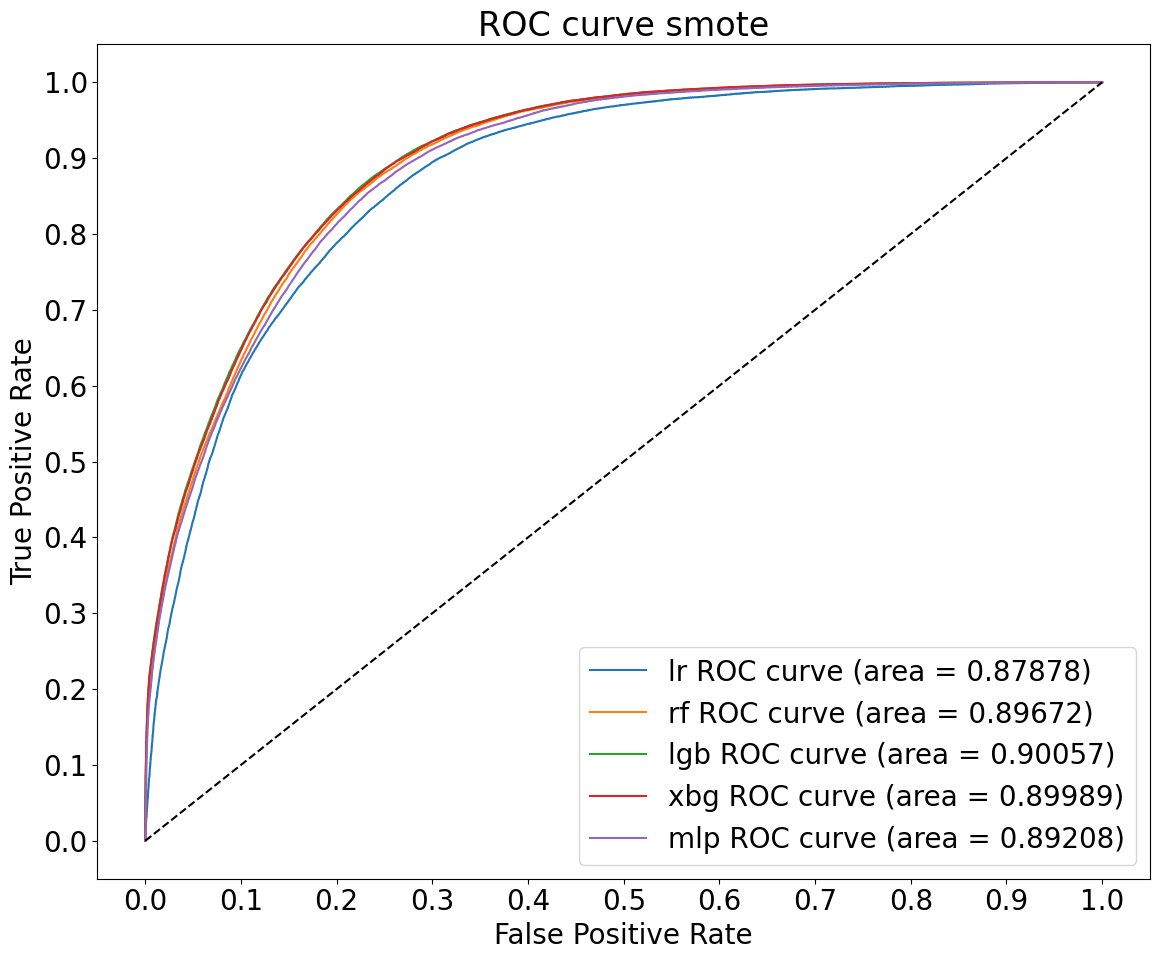

In [31]:
fig, _ = plot_multi_roc_curve([y_test,y_test,y_test,y_test,y_test], smote_predictions, title='smote',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/roc_smote.png')

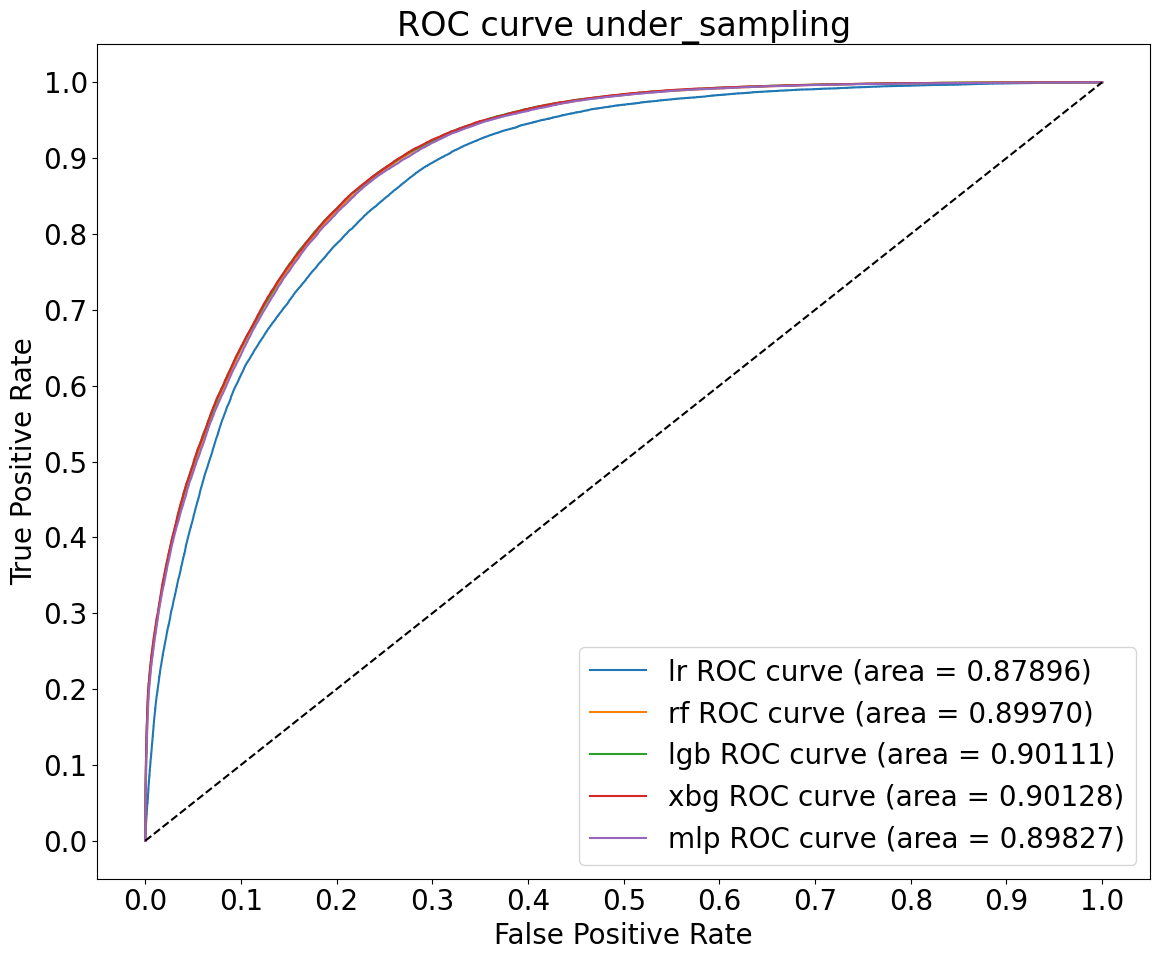

In [32]:
fig, _ = plot_multi_roc_curve([y_test,y_test,y_test,y_test,y_test], under_sampling_predictions, title='under_sampling',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/roc_under_sampling.png')